# Importing 

In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
from BaseNetwork import BaseNetwork
from torch.nn import L1Loss
from torch.optim import Adam, lr_scheduler
import numpy as np
from FNN import FNN
from Seq2Seq import Seq2Seq
import pandas as pd

%load_ext autoreload
%autoreload 2

# Load Data

### The data is loaded twice: With/without time of day

In [2]:
previous_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        timeofday = True)
train2 = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        )

validation = MoviaBusDataset('../data/validation', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)
validation2 = MoviaBusDataset('../data/validation', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps)

test = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)
test2 = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps)


# Historical average

In [3]:
train_his_mean = pd.concat(train.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
train_his_mean = train_his_mean.pivot(index='Time', columns='LinkRef',values='Speed').groupby(['TimeOfDay']).mean()

validation_his_mean = pd.concat(validation.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
validation_his_mean = validation_his_mean.pivot(index='Time', columns='LinkRef',values='Speed')

n_valdays = 2
n_measure = int(len(validation_his_mean)/n_valdays)
valday1 = validation_his_mean[0*n_measure:1*n_measure].groupby(['TimeOfDay']).mean()
valday2 = validation_his_mean[1*n_measure:2*n_measure].groupby(['TimeOfDay']).mean()

test_his_mean = pd.concat(test.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
test_his_mean = test_his_mean.pivot(index='Time', columns='LinkRef',values='Speed')

n_testdays = 3
n_measure = int(len(test_his_mean)/n_testdays)
testday1 = test_his_mean[0*n_measure:1*n_measure].groupby(['TimeOfDay']).mean()
testday2 = test_his_mean[1*n_measure:2*n_measure].groupby(['TimeOfDay']).mean()
testday3 = test_his_mean[2*n_measure:3*n_measure].groupby(['TimeOfDay']).mean()

MAE_his_average = np.mean([abs(testday1-train_his_mean).mean().mean(),abs(testday2-train_his_mean).mean().mean(),
                           abs(testday3-train_his_mean).mean().mean(),abs(valday1-train_his_mean).mean().mean(),
                           abs(valday2-train_his_mean).mean().mean()])
print('Mean Absolute Error: ',MAE_his_average) 

Mean Absolute Error:  1.5855474700159466


# Pre-modelling 

In [4]:
#The training set is reorganized such that it easlily can be used for computing the historical mean 
train_all = pd.concat(train.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
train_road_mean = train_all.pivot(index='Time', columns='LinkRef',values='Speed').groupby(['TimeOfDay']).mean()

#Removing trend 
train.remove_trend()
validation.remove_trend(train._historical_average)
test.remove_trend(train._historical_average)

train2.remove_trend()
validation2.remove_trend(train2._historical_average)
test2.remove_trend(train2._historical_average)

#Normalize the data-set wihtout the time-of-day parameter 
train2.normalize(individual_roads=False)
validation2.normalize(train2.mean, train2.std)
test2.normalize(train2.mean, train2.std)

# FNN 

epoch =  0  train loss = 1.402   validation loss = 1.530   output_std = 0.626
Model saved as FNN.pt
epoch =  2  train loss = 1.393   validation loss = 1.526   output_std = 0.703
Model saved as FNN.pt
epoch =  4  train loss = 1.390   validation loss = 1.524   output_std = 0.721
Model saved as FNN.pt
epoch =  6  train loss = 1.389   validation loss = 1.522   output_std = 0.724
Model saved as FNN.pt
epoch =  8  train loss = 1.388   validation loss = 1.522   output_std = 0.738
Model saved as FNN.pt
epoch = 10  train loss = 1.387   validation loss = 1.521   output_std = 0.743
Model saved as FNN.pt
epoch = 12  train loss = 1.387   validation loss = 1.521   output_std = 0.756
Model saved as FNN.pt
epoch = 14  train loss = 1.387   validation loss = 1.521   output_std = 0.754
Model saved as FNN.pt
epoch = 16  train loss = 1.387   validation loss = 1.521   output_std = 0.760
Model saved as FNN.pt
epoch = 18  train loss = 1.386   validation loss = 1.521   output_std = 0.762
epoch = 20  train loss

<IPython.core.display.Javascript object>


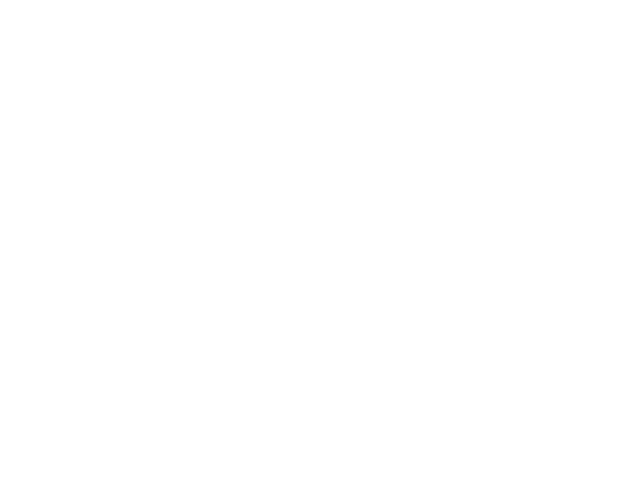

In [5]:
net_FNN = FNN(num_hidden=20)

optimizer_fun = lambda param : Adam(param, lr=1e-2, weight_decay=0)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=25, gamma=0.1)
criterion = L1Loss()

net_FNN.train_network(train, validation,batch_size=batch_size, 
                  num_epochs=50,
                  optimizer_fun=optimizer_fun,
                  scheduler_fun=scheduler_fun,
                  criterion=criterion)

validation_scores=[net_FNN.get_MAE_score(validation,timestep=i) for i in range(1,prediction_steps+1)]
print('Validation score:\n',validation_scores)
print('\nMean validation score for all timesteps:\n',sum(validation_scores)/len(validation_scores))

test_scores=[net_FNN.get_MAE_score(test,timestep=i) for i in range(1,prediction_steps+1)]
print('\nTest score:\n',test_scores)
print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

%matplotlib notebook
net_FNN.visualize_road(test, timesteps=6, road=16)

# Sequence2Sequence 

epoch =  0  train loss = 0.706   validation loss = 0.795   output_std = 0.246
Model saved as Sequence2Sequence.pt
epoch =  2  train loss = 0.675   validation loss = 0.786   output_std = 0.281
Model saved as Sequence2Sequence.pt
epoch =  4  train loss = 0.661   validation loss = 0.789   output_std = 0.310
epoch =  6  train loss = 0.646   validation loss = 0.791   output_std = 0.337
epoch =  8  train loss = 0.636   validation loss = 0.793   output_std = 0.345
Validation score:
 [1.5178208351135254, 1.521044135093689, 1.52279794216156, 1.525673747062683, 1.5313348770141602, 1.5344130992889404]

Mean validation score for all timesteps:
 1.5255141059557598

Test score:
 [1.5177778005599976, 1.5170857906341553, 1.5186326503753662, 1.519917368888855, 1.5233652591705322, 1.5249758958816528]

Mean test score for all timesteps:
 1.5202924609184265


<IPython.core.display.Javascript object>


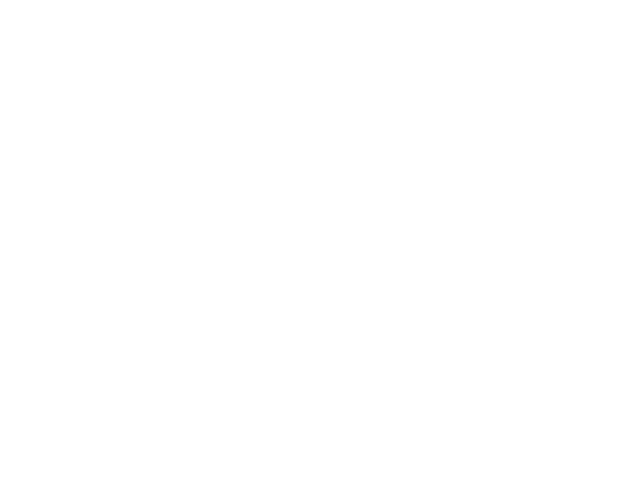

In [6]:
net_s2s = Seq2Seq()

optimizer_fun = lambda param : Adam(param, lr=1e-3, weight_decay=1e-4)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
criterion = L1Loss()

net_s2s.train_network(train2, validation2 ,batch_size=10, 
                  num_epochs=10,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  criterion=criterion,
                  shuffle=True,
                 target_to_net=True)

net_s2s._BaseNetwork__target_to_net = True

validation_scores=[net_s2s.get_MAE_score(validation2,timestep=i) for i in range(1,prediction_steps+1)]
print('Validation score:\n',validation_scores)
print('\nMean validation score for all timesteps:\n',sum(validation_scores)/len(validation_scores))

test_scores=[net_s2s.get_MAE_score(test2,timestep=i) for i in range(1,prediction_steps+1)]
print('\nTest score:\n',test_scores)
print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

%matplotlib notebook
time,_,tar= net_s2s.visualize_road(validation2,timesteps=6, road=16,return_values=True)

# DCRNN

In [7]:
%run ../notebooks/run_DCRNN.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
train x:  (1519, 6, 192, 2) y: (1519, 6, 192, 2)
val x:  (193, 6, 192, 2) y: (193, 6, 192, 2)
test x:  (295, 6, 192, 2) y: (295, 6, 192, 2)
2019-01-02 16:37:11,401 - INFO - Log directory: data/model/dcrnn_R_2_h_6_64-64_lr_0.01_bs_32_0102163711/
2019-01-02 16:37:11,403 - INFO - {'base_dir': 'data/model', 'log_level': 'INFO', 'data': {'batch_size': 32, 'dataset_dir': 'movia/data', 'test_batch_size': 32, 'val_batch_size': 32, 'graph_pkl_filename': 'movia/adj_mx.pkl'}, 'model': {'cl_decay_steps': 2000, 'filter_type': 'random_walk', 'horizon': 6, 'input_dim': 2, 'l1_decay': 0, 'max_diffusion_step': 2, 'num_nodes': 192, 'num_rnn_layers': 2, 'output_dim': 1, 'rnn_units': 64, 'seq_len': 6, 'use_curriculum_learning': True}, 'train': {'base_lr': 0.01, 'dropout': 0, 'epoch': 0, 'epochs': 100, 'epsilon': 0.001, 'global_step': 0, 'lr_decay_ratio': 0.1, 'max_grad_norm': 5, 'max_to_keep': 100, 'min_learning_rate':

2019-01-02 16:39:08,818 - INFO - Val loss decrease from 1.5443 to 1.5442, saving to data/model/dcrnn_R_2_h_6_64-64_lr_0.01_bs_32_0102163711/models-1.5442-1344
2019-01-02 16:39:12,878 - INFO - Epoch [28/100] (1392) train_mae: 1.3510, val_mae: 1.5441 lr:0.001000 4.1s
2019-01-02 16:39:13,006 - INFO - Val loss decrease from 1.5442 to 1.5441, saving to data/model/dcrnn_R_2_h_6_64-64_lr_0.01_bs_32_0102163711/models-1.5441-1392
2019-01-02 16:39:16,844 - INFO - Epoch [29/100] (1440) train_mae: 1.3508, val_mae: 1.5441 lr:0.001000 3.8s
2019-01-02 16:39:17,701 - INFO - Horizon 01, MAE: 1.47, MAPE: 2.9844, RMSE: 2.04
2019-01-02 16:39:17,704 - INFO - Horizon 02, MAE: 1.52, MAPE: 2.4573, RMSE: 2.10
2019-01-02 16:39:17,707 - INFO - Horizon 03, MAE: 1.53, MAPE: 2.1619, RMSE: 2.13
2019-01-02 16:39:17,710 - INFO - Horizon 04, MAE: 1.54, MAPE: 1.9906, RMSE: 2.14
2019-01-02 16:39:17,713 - INFO - Horizon 05, MAE: 1.54, MAPE: 1.9483, RMSE: 2.14
2019-01-02 16:39:17,716 - INFO - Horizon 06, MAE: 1.55, MAPE: 1

2019-01-02 16:42:15,086 - INFO - Epoch [73/100] (3552) train_mae: 1.3505, val_mae: 1.5440 lr:0.000002 4.2s
2019-01-02 16:42:19,664 - INFO - Epoch [74/100] (3600) train_mae: 1.3507, val_mae: 1.5440 lr:0.000002 4.6s
2019-01-02 16:42:23,356 - INFO - Epoch [75/100] (3648) train_mae: 1.3505, val_mae: 1.5440 lr:0.000002 3.7s
2019-01-02 16:42:27,419 - INFO - Epoch [76/100] (3696) train_mae: 1.3507, val_mae: 1.5440 lr:0.000002 4.1s
2019-01-02 16:42:32,024 - INFO - Epoch [77/100] (3744) train_mae: 1.3505, val_mae: 1.5440 lr:0.000002 4.6s
2019-01-02 16:42:35,836 - INFO - Epoch [78/100] (3792) train_mae: 1.3506, val_mae: 1.5440 lr:0.000002 3.8s
2019-01-02 16:42:39,645 - INFO - Epoch [79/100] (3840) train_mae: 1.3507, val_mae: 1.5440 lr:0.000002 3.8s
2019-01-02 16:42:40,369 - INFO - Horizon 01, MAE: 1.47, MAPE: 2.9967, RMSE: 2.04
2019-01-02 16:42:40,372 - INFO - Horizon 02, MAE: 1.52, MAPE: 2.4811, RMSE: 2.10
2019-01-02 16:42:40,375 - INFO - Horizon 03, MAE: 1.53, MAPE: 2.1734, RMSE: 2.13
2019-01-

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [8]:
road_nr = 16
time_steps_nr = 6

In [9]:
import numpy as np
with np.load('../DCRNN/movia/out.npz') as data:
    # also contains groundtruth
    test_scores= np.abs(data['predictions'] - data['groundtruth']).mean(axis=1).mean(axis=1)
    print('\nTest score:\n',test_scores)
    print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

    out_dcrnn = data['predictions'][:,:,road_nr]
net_dcrnn = out_dcrnn[time_steps_nr-1,0:90]+train_his_mean.values[6:-6,road_nr]


Test score:
 [1.47143992 1.51641353 1.53088039 1.53797708 1.54217369 1.54734478]

Mean test score for all timesteps:
 1.5243715636794082


<IPython.core.display.Javascript object>


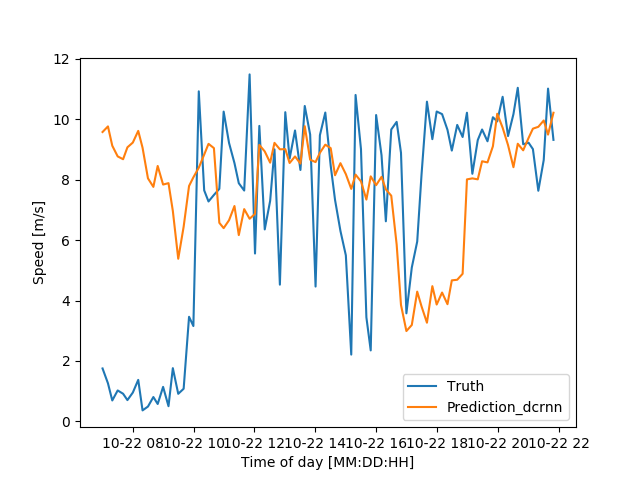

In [10]:
%matplotlib notebook
plt.plot(time[0:90],tar[0:90], label='Truth')
plt.plot(time[0:90],net_dcrnn,label='Prediction_dcrnn')
plt.legend()
plt.xlabel('Time of day [MM:DD:HH]')
plt.ylabel('Speed [m/s]')
plt.rcParams["figure.figsize"] = [10,4]
plt.show()